In [1]:
# !pip install -U accelerate
# !pip install -U transformers
# !pip install transformers[torch]
# !pip install accelerate -U
# !pip install rouge_score
# !pip install evaluate

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import AutoTokenizer
import evaluate
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)

# Importing Text Data

In [4]:
# caption_loc = '/kaggle/input/flickr8k/captions.txt'
# image_loc =  '/kaggle/input/flickr8k/Images/'
image_loc = 'Images/'
caption_loc = 'captions.txt'

In [5]:
text_data = pd.read_csv(caption_loc)
text_data

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 2 columns]

# Data Preparation

In [6]:
text_data.rename(columns={"caption":"image_repeat","caption_text":"caption"},inplace=True)
text_data.drop(text_data[text_data['image']=="2258277193_586949ec62.jpg.1"].index, inplace=True)
text_data.reset_index(drop=True, inplace=True)

In [7]:
# Drop rows with given value of column
text_data_train = text_data.drop(text_data[text_data['image_repeat']==0].index)
text_data_train.reset_index(drop=True, inplace=True)

# text_data_train = text_data[text_data['image_repeat']==1]
# text_data_train.reset_index(drop=True, inplace=True)
text_data_val = text_data[ text_data['image_repeat']==0 ]
text_data_val.reset_index(drop=True, inplace=True)
text_data_train.shape, text_data_val.shape

((40455, 2), (0, 2))

In [8]:
text_data_train['image'].unique().shape # The 8k images

(8091,)

# Vision Encoder Decoder Models

In [9]:
batch_size = 70
epochs = 70

In [243]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", add_special_tokens=True)

if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "bert-base-uncased")

# ids
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.10.crossattention.self.value.bias', 'bert.encoder.layer.11.crossattention.self.value.weight', 'bert.encoder.layer.11.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.11.crossattention.self.key.bias', 'bert.encoder.layer.7.crossattention.self.value.weight', 'bert.encoder.layer.10.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.self.query.bias', 'bert.encoder.layer.6.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.10.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.5.crossattention.self.key.weight', 'bert.encoder.layer.9.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattention.self.key.weight', 'bert.encoder.layer.4.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.3.crossattention.output.dense.bi

In [244]:
from torch.utils.data import Dataset
# from datasets import Dataset
image_height = 224
image_width = 224

class ImageCaptionDataset(Dataset):
    def __init__(self, image_path, text_df, tokenizer, image_height,image_width):
        self.image_path = image_path
        self.text_df = text_df
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width
        
    def __len__(self):
        return self.text_df.shape[0]
    
    def __getitem__(self,index):
        path_filename = self.image_path + text_data_train.iloc[index]['image']
        # print(text_data_train)
        # print(path_filename)
        image = np.array(Image.open( path_filename ).resize((self.image_width, self.image_height)), dtype=np.uint8)
        image = torch.tensor(np.moveaxis(image, -1, 0))
        # print( text_data_train.iloc[index]['image_repeat'])
        # print('cow')
        caption_token = self.tokenizer( text_data_train.iloc[index]['image_repeat'], add_special_tokens=True, padding="max_length", max_length=32, truncation = True  ).input_ids 
        # print('goat')
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token] 
        return {"pixel_values": image.squeeze(), "caption": torch.tensor(caption_token)} #, "caption":self.captions[index]}


train_dataset = ImageCaptionDataset( image_path=image_loc, text_df=text_data_train , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )
val_dataset = ImageCaptionDataset( image_path=image_loc, text_df=text_data_val , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )

# Display few images

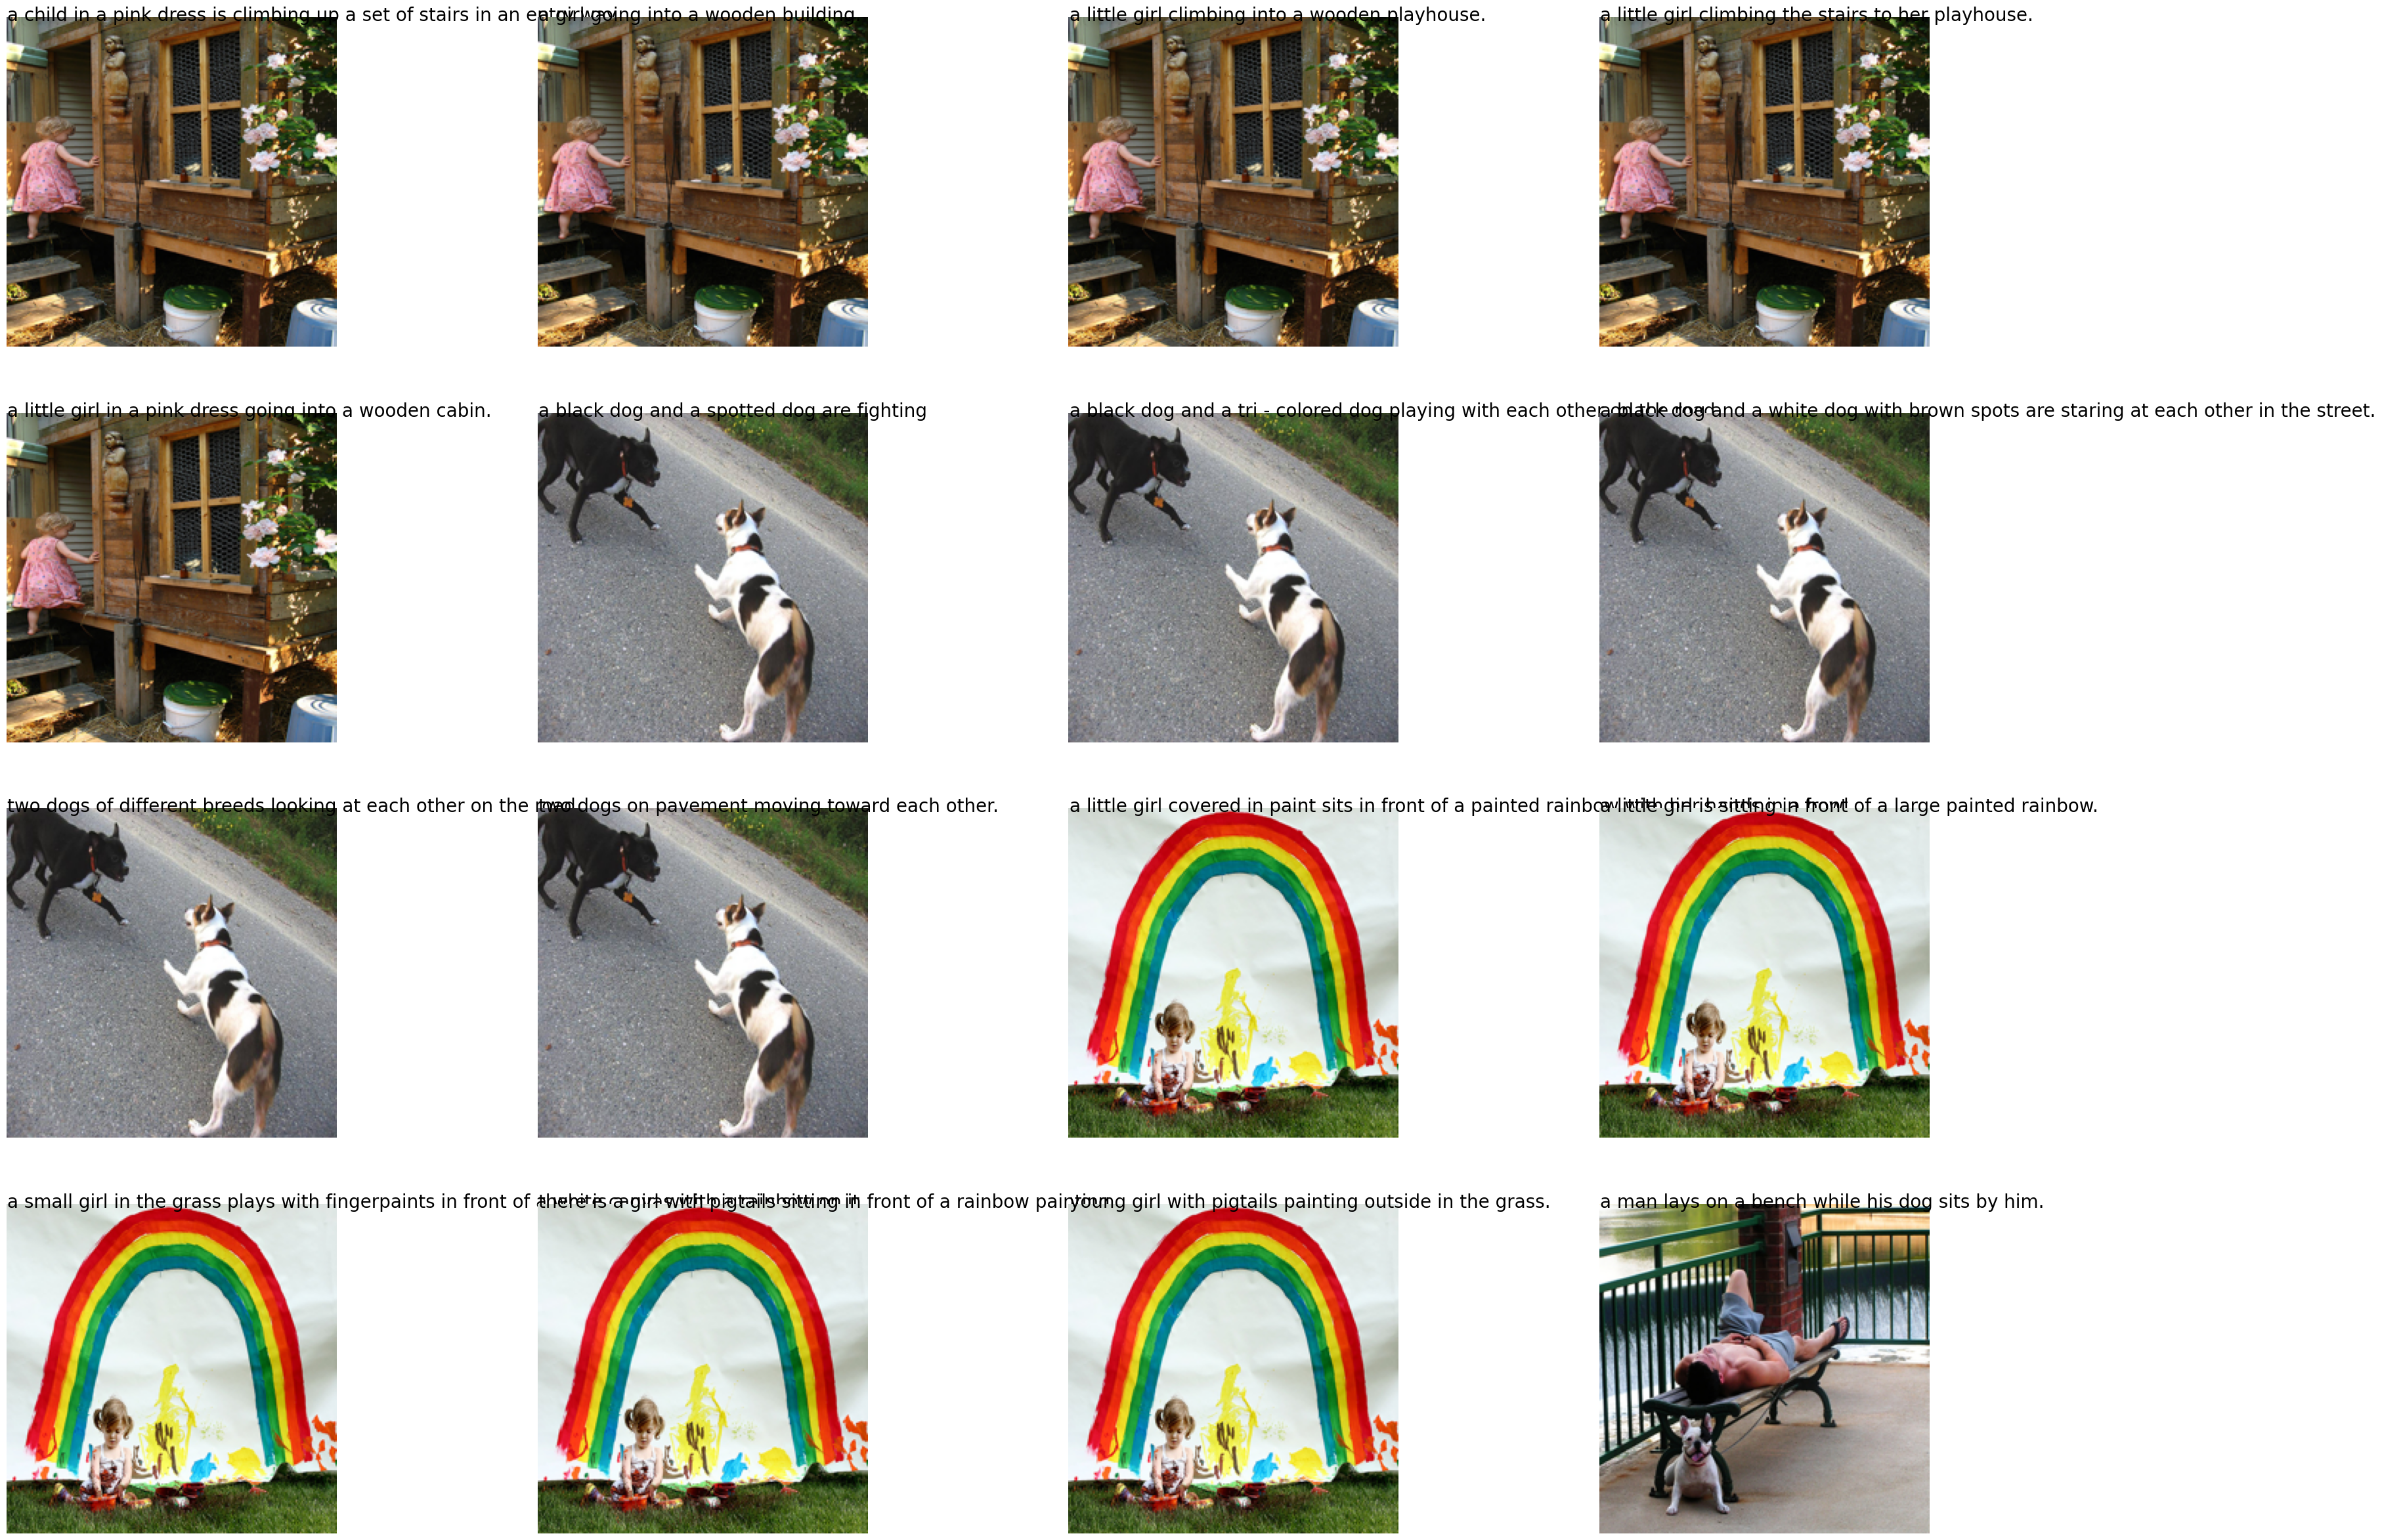

In [245]:
# Display fews images
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.moveaxis(train_dataset.__getitem__(i)['pixel_values'].numpy(), 0, -1))
    plt.axis('off')
    # caption (small font size)
    caption = []
    for word in decoder_tokenizer.decode( [0 if token==-100 else token for token in train_dataset.__getitem__(i)['caption'].numpy()] ).split():
        if word not in decoder_tokenizer.all_special_tokens:
            caption.append(word)
    caption = " ".join(caption)
    plt.text(0, 2, caption, fontsize=20)
    # largen plot size
    plt.gcf().set_size_inches(40, 30)
    
plt.show()

In [246]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [34]:
len(train_dataset)

40455

In [36]:
len(train_dataloader)*batch_size/5

8092.0

# Training Setup

In [15]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

from transformers import get_scheduler
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/5), num_training_steps=num_training_steps )


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
model.to(device)
print(device)
# Set GPU/CPU

cuda


# Training Model

In [16]:
from tqdm.auto import tqdm
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(epochs):
    losses = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values = batch['pixel_values'], labels=batch['caption']) # decoder_input_ids=batch['caption_token'],
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        losses.append(loss)

    if epoch in [10, 20, 30, 40, 50, 60, 70]: 
        model.save_pretrained(f"Save_at_{epoch}_epochs.pt")
        print(loss)
        print(f'Saved at {epoch}')
        
    print('Epoch: {}, Loss: {:.4f}'.format(epoch, sum(losses)))

  0%|          | 0/40460 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0, Loss: 3931.5718
Epoch: 1, Loss: 2112.4294
Epoch: 2, Loss: 1737.7455
Epoch: 3, Loss: 1577.7609
Epoch: 4, Loss: 1476.5564
Epoch: 5, Loss: 1407.1489
Epoch: 6, Loss: 1340.1541
Epoch: 7, Loss: 1267.4630
Epoch: 8, Loss: 1193.3281
Epoch: 9, Loss: 1118.7729
tensor(1.8434, device='cuda:0', grad_fn=<NllLossBackward0>)
Saved at 10
Epoch: 10, Loss: 1043.1829
Epoch: 11, Loss: 969.3834
Epoch: 12, Loss: 896.3239
Epoch: 13, Loss: 824.9969
Epoch: 14, Loss: 751.9768
Epoch: 15, Loss: 676.6175
Epoch: 16, Loss: 614.0016
Epoch: 17, Loss: 546.5691
Epoch: 18, Loss: 492.5757
Epoch: 19, Loss: 444.3154
tensor(0.7508, device='cuda:0', grad_fn=<NllLossBackward0>)
Saved at 20
Epoch: 20, Loss: 401.1593
Epoch: 21, Loss: 363.0846
Epoch: 22, Loss: 331.8840
Epoch: 23, Loss: 303.8830
Epoch: 24, Loss: 279.2800
Epoch: 25, Loss: 260.0904
Epoch: 26, Loss: 240.4738
Epoch: 27, Loss: 226.9514
Epoch: 28, Loss: 213.3085
Epoch: 29, Loss: 202.5739
tensor(0.3950, device='cuda:0', grad_fn=<NllLossBackward0>)
Saved at 30
Epo

In [17]:
# plt.plot(losses.cpu())

# Evaluating Model

In [18]:
# metric = evaluate.load('rouge')

# model.eval()
# losses = []
# i = 0
# for batch in train_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption'])

#     logits = outputs.logits
#     loss = outputs.loss
#     losses.append(loss)
#     predictions = torch.argmax(logits, dim=-1)
#     predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
#     predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
#     references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption'].tolist() ]
#     metric.add_batch( predictions=predictions, references=references )
    
# train_rouge_score = metric.compute()
# print( " Train Loss: ", torch.sum(torch.tensor(losses)) )
# print(" Rouge Score on Train Set: ", train_rouge_score )

In [19]:
# metric = evaluate.load('rouge')

# model.eval()
# losses = []
# for batch in val_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = model(pixel_values=batch['pixel_values'],labels=batch['caption'])
    
#     logits = outputs.logits
#     loss = outputs.loss
#     losses.append(loss)
#     predictions = torch.argmax(logits, dim=-1)
#     predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
#     predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
#     references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption'].tolist() ]
#     metric.add_batch( predictions=predictions, references=references )
    
# val_rouge_score = metric.compute()
# print( " Validation Loss: ", torch.sum(torch.tensor(losses)) )
# print(" Rouge Score on Validation Set: ", val_rouge_score )

# Saving Model

In [20]:
# Saving the model, including its configuration
model.save_pretrained("Save_final2.pt")

# Generating Captions

In [283]:
def generate_caption(image, model, tokenizer, device):
    # Convert image to tensor and move it to the appropriate device
    image = torch.unsqueeze(torch.tensor(image), 0).to(device)
    
    # Encode image using the model's encoder
    encoder_output = model.encoder(pixel_values=image)
    
    # Initialize the decoder input with the special token for start of sequence
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)
    
    # Initialize the list to hold generated token IDs
    generated_ids = []
    
    # Set maximum length for generated caption
    max_length = 32
    
    # Generate tokens one by one using the decoder
    for _ in range(max_length):
        # Generate next token
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        # Append the token to the list of generated tokens
        generated_ids.append(next_token_id.item())
        
        # Break if the end of sequence token is generated
        if next_token_id.item() == tokenizer.sep_token_id:
            break
        
        # Prepare input for the next iteration
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)
    
    # Decode the generated token IDs into a caption string
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    # Display the image and print the generated caption
    image = np.moveaxis(image[0].cpu().numpy(), 0, -1)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("Generated Caption:", generated_caption)
    
    return generated_caption


In [26]:
# Loading model
model = VisionEncoderDecoderModel.from_pretrained("Save_final.pt").to('cuda')

In [248]:
train_dataset.__getitem__(i)['pixel_values'].numpy().shape

(3, 224, 224)

In [306]:
# # Example usage
# for i in range(1,100,5):
#     pred_caption = generate_caption(
#         image=train_dataset.__getitem__(i)['pixel_values'].numpy(),
#         model=model,
#         tokenizer=decoder_tokenizer,
#         device=device
#     )


# Testing with Random Images

In [240]:
train_dataset = ImageCaptionDataset( image_path='/home/arjun/Desktop/java joji/Screenshot from 2024-04-05 09-15-54.png', text_df=text_data_train , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )
val_dataloader = DataLoader(train_dataset, batch_size=batch_size)

In [255]:
import numpy as np
from PIL import Image

def convert_image(image_path):

    image = Image.open(image_path)
    image = image.resize((224, 224))
    image_array = np.array(image)

    if image_array.shape[2] == 4:
        image_array = image_array[:, :, :3]
    elif image_array.shape[2] == 1:
        image_array = np.repeat(image_array, 3, axis=2)
    image_array = np.transpose(image_array, (2, 0, 1))
    
    return image_array

In [303]:
# Select model
model = VisionEncoderDecoderModel.from_pretrained("Save_at_50_epochs.pt").to('cuda')

### Train Data

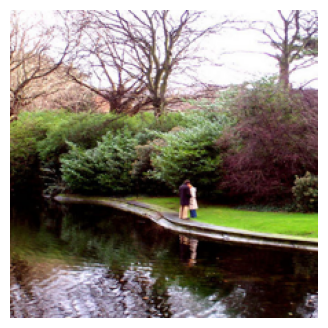

Generated Caption: two people stand together on the edge of the water on the grass.


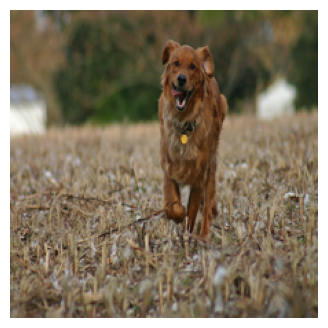

Generated Caption: a brown dog is running through the field.


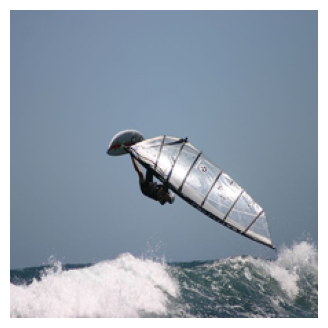

Generated Caption: a man jumps over a wave on his surfboard.


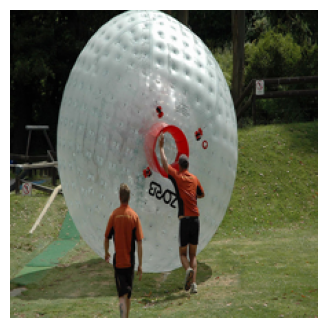

Generated Caption: two men are trying to push this very large inflatable golf ball


In [308]:
for im in ['im1.jpg', 'im2.jpg','im3.jpg' ,'im4.jpg' ]:

    pred_caption = generate_caption(
            image=convert_image(im),
            model=model.to('cuda'),
            tokenizer=decoder_tokenizer,
            device=device
        )

### Test Data

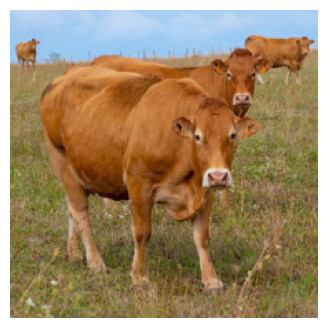

Generated Caption: a large brown dog is walking over a grassy field.


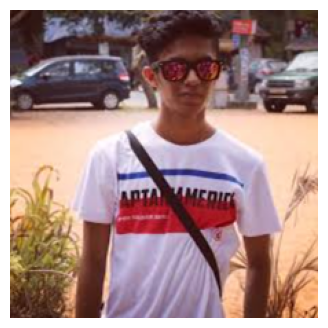

Generated Caption: a girl in a purple shirt and a red and white polka dot shirt is sitting on a white couch.


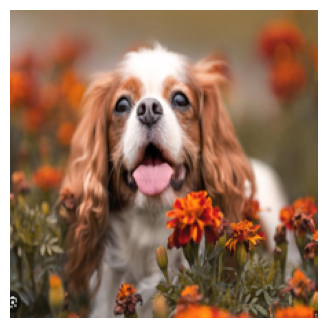

Generated Caption: a woman wearing a orange coat and white hat looks at the camera.


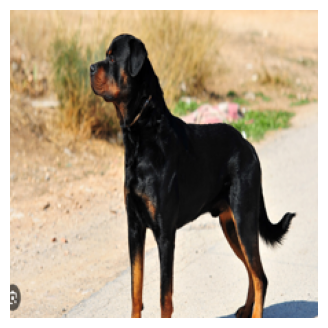

Generated Caption: a black dog is jumping on a white couch.


In [312]:
for im in ['im5.png', 'im6.png','im7.png', 'im8.png' ]:

    pred_caption = generate_caption(
            image=convert_image(im),
            model=model.to('cuda'),
            tokenizer=decoder_tokenizer,
            device=device
        )